# レーザーテック 株価（日足）

In [1]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '6920.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-08 00:00:00+09:00,42034.587353,42472.655056,41337.661461,41556.695312,6154700,0.0,0.0
2024-05-09 00:00:00+09:00,41885.244261,42462.697117,40790.075050,40839.855469,6959000,0.0,0.0
2024-05-10 00:00:00+09:00,40800.031366,41138.538215,40222.578507,40760.207031,5240200,0.0,0.0
2024-05-13 00:00:00+09:00,40929.461398,41158.451331,40352.008525,40441.613281,4997900,0.0,0.0
2024-05-14 00:00:00+09:00,40441.612850,41596.518584,40411.744598,41586.562500,5040400,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-01 00:00:00+09:00,20500.000000,20505.000000,19500.000000,19615.000000,14824200,0.0,0.0
2024-11-05 00:00:00+09:00,19620.000000,20300.000000,19555.000000,20000.000000,7941400,0.0,0.0
2024-11-06 00:00:00+09:00,20000.000000,20780.000000,19785.000000,20730.000000,8720700,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

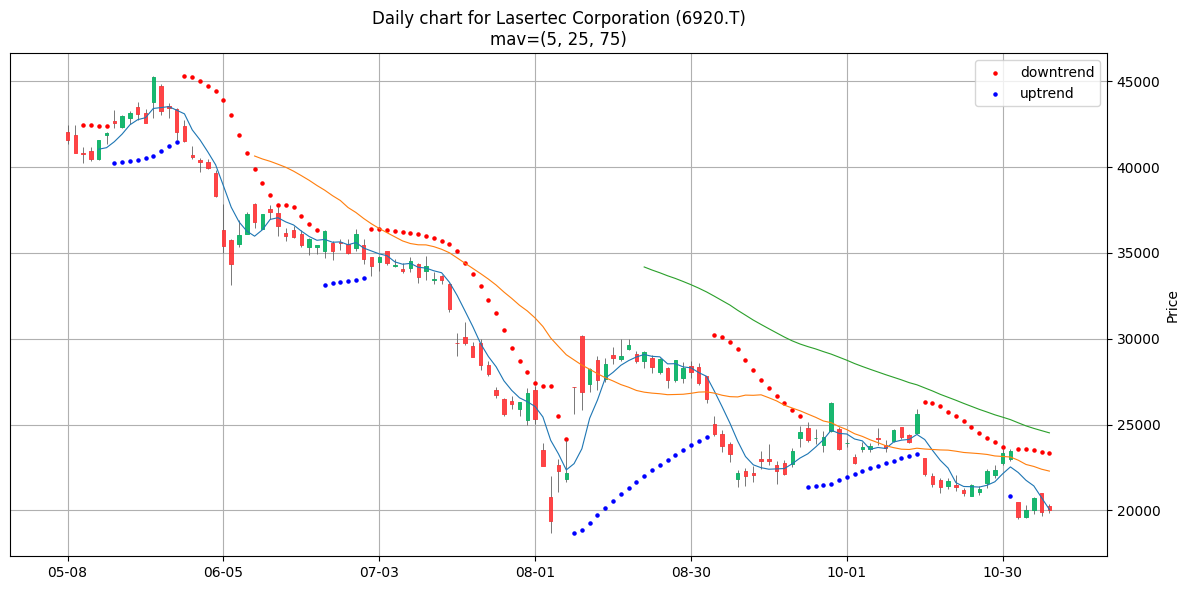

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='yahoo',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_6920.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-11-07 00:00:00+09:00    19900.0
2024-11-08 00:00:00+09:00    20050.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-11-07 00:00:00+09:00      NaN
2024-11-08 00:00:00+09:00    150.0
Name: Close, dtype: float64